## Data PreProcessing 

#### LIBRARY IMPORT

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from xgboost import XGBClassifier

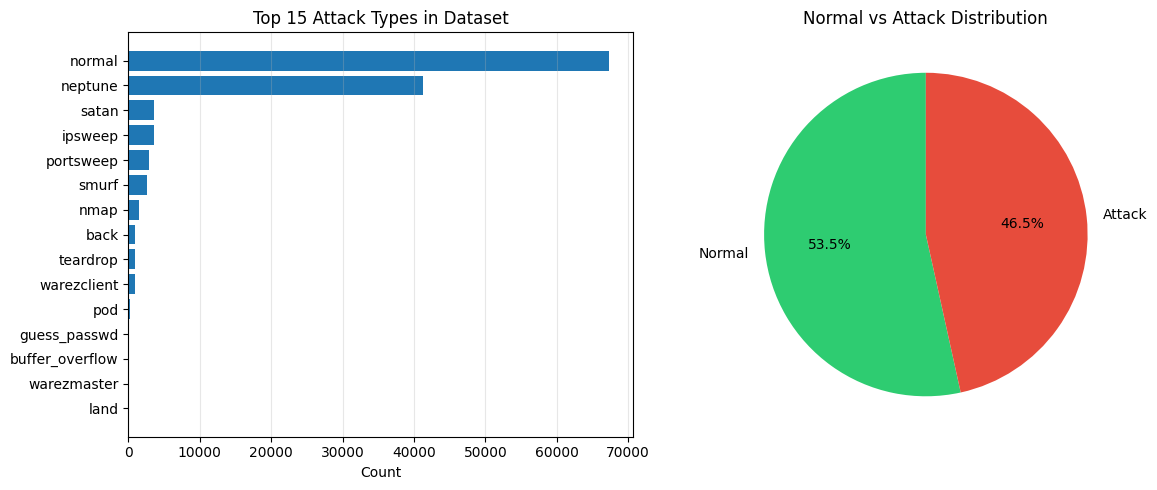

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

data = pd.read_csv('Data/KDDTrain+.txt', header=None, names=col_names)
data.drop(['difficulty_level'], axis=1, inplace=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
label_counts = data['label'].value_counts().head(15)
plt.barh(range(len(label_counts)), label_counts.values)
plt.yticks(range(len(label_counts)), label_counts.index)
plt.xlabel('Count')
plt.title('Top 15 Attack Types in Dataset')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.subplot(1, 2, 2)
normal_count = (data['label'] == 'normal').sum()
attack_count = (data['label'] != 'normal').sum()
plt.pie([normal_count, attack_count], labels=['Normal', 'Attack'], autopct='%1.1f%%', 
        colors=['#2ecc71', '#e74c3c'], startangle=90)
plt.title('Normal vs Attack Distribution')

plt.tight_layout()
plt.show()

In [3]:
le_protocol = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()

data['protocol_type'] = le_protocol.fit_transform(data['protocol_type'])
data['service'] = le_service.fit_transform(data['service'])
data['flag'] = le_flag.fit_transform(data['flag'])

print(f"Data shape: {data.shape}")

Data shape: (125973, 42)


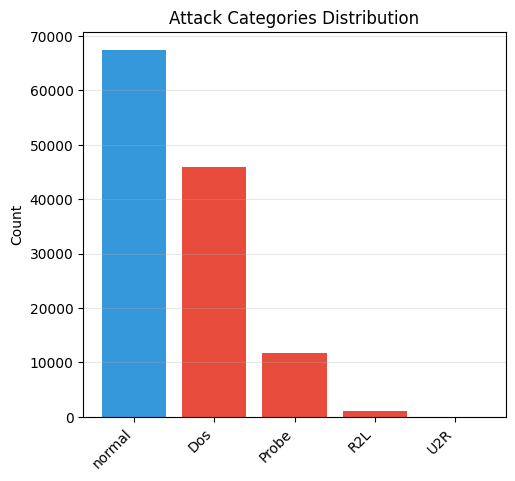

In [4]:
def change_label(df):
  df['label'] = df['label'].replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos')
  df['label'] = df['label'].replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L')
  df['label'] = df['label'].replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe')
  df['label'] = df['label'].replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R')

change_label(data)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
label_counts = data.label.value_counts()
colors = ['#3498db' if label == 'normal' else '#e74c3c' for label in label_counts.index]
bars = plt.bar(range(len(label_counts)), label_counts.values, color=colors)
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Attack Categories Distribution')
plt.grid(axis='y', alpha=0.3)


plt.show()

In [5]:
data['intrusion'] = data['label'].apply(lambda x: 0 if x == 'normal' else 1)

#### Feature Selection using correlation

In [6]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr = numeric_data.corr()
corr_y = abs(corr['intrusion'])
selected_features = corr_y[properlycorr_y > 0.5].index.tolist()

if 'intrusion' in selected_features:
    selected_features.remove('intrusion')
if 'label' in selected_features:
    selected_features.remove('label')

X = data[selected_features].values
y = data['intrusion'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Handle Nans / Infinites just in case 
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

print(f"\nData Split:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training samples: {len(y_train)} ({len(y_train)/len(y)*100:.1f}%)")
print(f"Test samples: {len(y_test)} ({len(y_test)/len(y)*100:.1f}%)")


Data Split:
Training set shape: (94479, 10)
Test set shape: (31494, 10)
Training samples: 94479 (75.0%)
Test samples: 31494 (25.0%)


### Model Implementation

##### Random Forest

In [7]:
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Measure training time
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

print(f"Random Forest training completed in {rf_training_time:.2f} seconds")

rf_pred = rf_model.predict(X_test)


Training Random Forest...
Random Forest training completed in 4.68 seconds


##### XGBoost Classifier

In [ ]:
print("Training XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Measure training time
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

print(f"XGBoost training completed in {xgb_training_time:.2f} seconds")

xgb_pred = xgb_model.predict(X_test)

##### LSTM Deep Learning

Training LSTM...
Epoch 1/10


E0000 00:00:1768382662.105978  112956 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1768382662.122066  112956 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/brightshot/Jupyter/notebook/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9202 - loss: 0.2134 - val_accuracy: 0.9445 - val_loss: 0.1496
Epoch 2/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9432 - loss: 0.1546 - val_accuracy: 0.9504 - val_loss: 0.1397
Epoch 3/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9470 - loss: 0.1479 - val_accuracy: 0.9519 - val_loss: 0.1359
Epoch 4/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9494 - loss: 0.1425 - val_accuracy: 0.9557 - val_loss: 0.1283
Epoch 5/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9496 - loss: 0.1393 - val_accuracy: 0.9563 - val_loss: 0.1301
Epoch 6/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 0.1364 - val_accuracy: 0.9552 - val_loss: 0.1293
Epoch 7/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9517 - loss: 0.1354 - val_accuracy: 0.9554 - val_loss: 0.1264
Epoch 8/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9531 - loss: 0.1331 - val_accurac

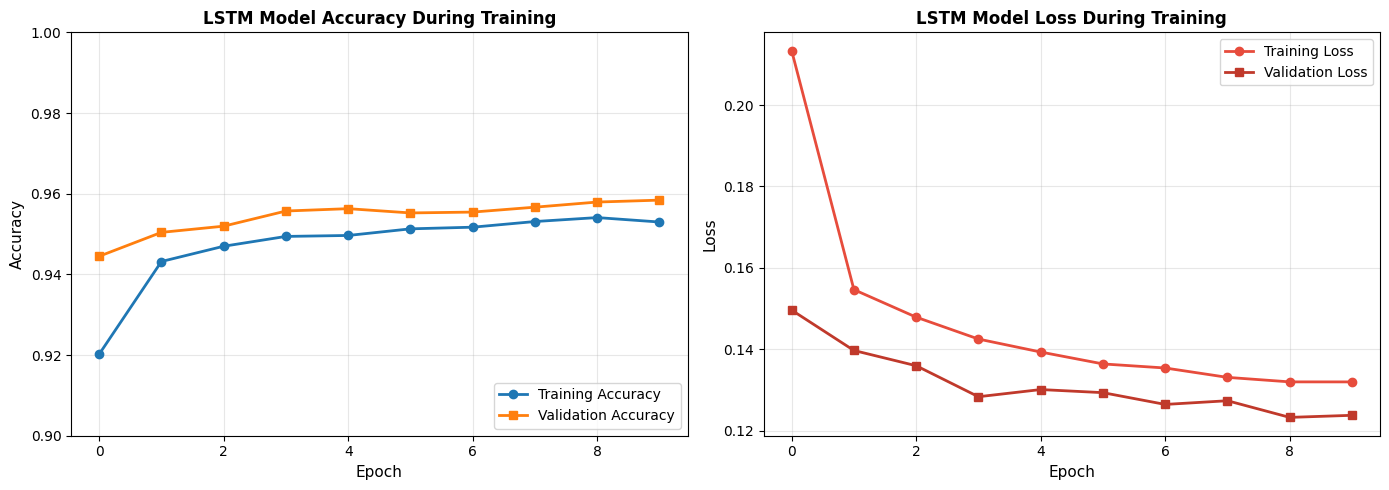

985/985 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [10]:
print("Training LSTM...")
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()

lstm_model.add(LSTM(64, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Measure training time
start_time = time.time()
history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
lstm_training_time = time.time() - start_time

print(f"\nLSTM training completed in {lstm_training_time:.2f} seconds")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('LSTM Model Accuracy During Training', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.ylim([0.9, 1.0])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', color='#e74c3c')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', color='#c0392b')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.title('LSTM Model Loss During Training', fontsize=12, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

lstm_pred_prob = lstm_model.predict(X_test_lstm)
lstm_pred = (lstm_pred_prob > 0.5).astype(int).flatten()

### Evaluation

In [11]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return [name, acc, prec, rec, f1]

# Collect results
results = []
results.append(evaluate_model("Random Forest", y_test, rf_pred))
results.append(evaluate_model("XGBoost", y_test, xgb_pred))
results.append(evaluate_model("LSTM", y_test, lstm_pred))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

##### model comparison


--- Comparative Analysis Results ---
           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.971487   0.974331  0.964402  0.969341
1        XGBoost  0.974598   0.976712  0.968750  0.972715
2           LSTM  0.958024   0.977954  0.931182  0.953995


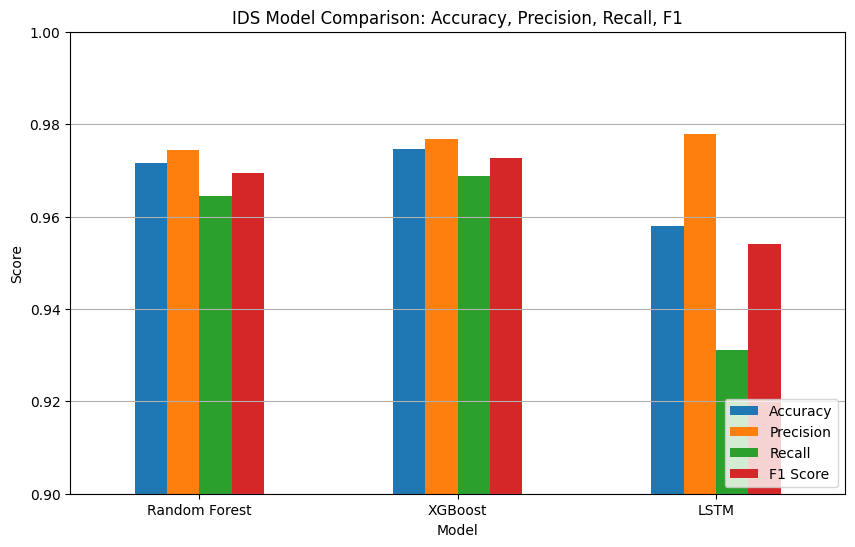


--- Detailed Classification Reports ---
Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     16774
           1       0.97      0.96      0.97     14720

    accuracy                           0.97     31494
   macro avg       0.97      0.97      0.97     31494
weighted avg       0.97      0.97      0.97     31494

XGBoost:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     16774
           1       0.98      0.97      0.97     14720

    accuracy                           0.97     31494
   macro avg       0.97      0.97      0.97     31494
weighted avg       0.97      0.97      0.97     31494

LSTM:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     16774
           1       0.98      0.93      0.95     14720

    accuracy                           0.96     31494
   macro avg       0.96      0.96      0.96     31494


In [12]:
# Display Results
print("\n--- Comparative Analysis Results ---")
print(results_df)

# Visualization of Results
results_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("IDS Model Comparison: Accuracy, Precision, Recall, F1")
plt.ylabel("Score")
plt.ylim(0.9, 1.0) # Zoom in to see differences in high-performing models
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

# Classification Reports
print("\n--- Detailed Classification Reports ---")
print("Random Forest:\n", classification_report(y_test, rf_pred))
print("XGBoost:\n", classification_report(y_test, xgb_pred))
print("LSTM:\n", classification_report(y_test, lstm_pred))